### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 100 объектов с 2-мя признаками
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

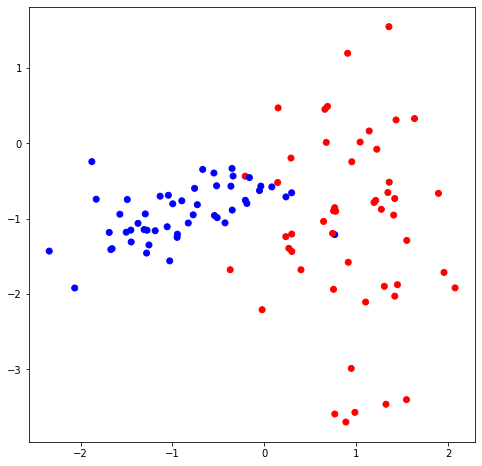

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [4]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
# Реализуем генерацию  N бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [6]:
# Класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        

# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        
    
    
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity


# Расчет прироста
def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


# Разбиение датасета в узле
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels


# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index


# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


# Формирование случайного леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest


# Классификация отдельного объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
    

# Формирование предсказания по выборке на одном дереве
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes



# Предсказание голосованием деревьев
def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [7]:
# Разобьем выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [8]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


def accuracy(train_answers,  test_answers, n_trees):
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    return (train_accuracy, test_accuracy)

In [9]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, train_result):
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(16, 7)

    # график обучающей выборки
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(train_result.forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    axs[0].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    axs[0].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    axs[0].set_title(f'Train accuracy={train_result.accuracy[0]:.2f}')

    # график тестовой выборки
    axs[1].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    axs[1].scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    axs[1].set_title(f'Test accuracy={train_result.accuracy[1]:.2f}')
    
    fig.suptitle(f'Number of trees: {train_result.n_trees}', fontsize=16)

In [10]:
class TrainResult():
    
    def __init__(self, n_trees, forest, train_answers, test_answers, accuracy):
        self.n_trees = n_trees
        self.forest = forest
        self.train_answers = train_answers
        self.test_answers = test_answers
        self.accuracy = accuracy
        
        
    def __str__(self):
        return f'''
        Количество деревьев случайного леса: {self.n_trees}
        Точность на обучающей выборке: {self.accuracy[0]:.3f}
        Точность на тестовой выборке: {self.accuracy[1]:.3f}
        '''
    
    def __repr__(self):
        return self.__str__()
        

def pipeline(n_trees):
    forest = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(forest, train_data)
    test_answers = tree_vote(forest, test_data)
    _accuracy = accuracy(train_answers, test_answers, n_trees)
    return TrainResult(n_trees, forest, train_answers, test_answers, _accuracy)

In [11]:
train_results = [pipeline(x) for x in [1, 3, 10, 50]]
print(train_results)

[
        Количество деревьев случайного леса: 1
        Точность на обучающей выборке: 95.714
        Точность на тестовой выборке: 90.000
        , 
        Количество деревьев случайного леса: 3
        Точность на обучающей выборке: 98.571
        Точность на тестовой выборке: 90.000
        , 
        Количество деревьев случайного леса: 10
        Точность на обучающей выборке: 98.571
        Точность на тестовой выборке: 83.333
        , 
        Количество деревьев случайного леса: 50
        Точность на обучающей выборке: 100.000
        Точность на тестовой выборке: 83.333
        ]


[None, None, None, None]

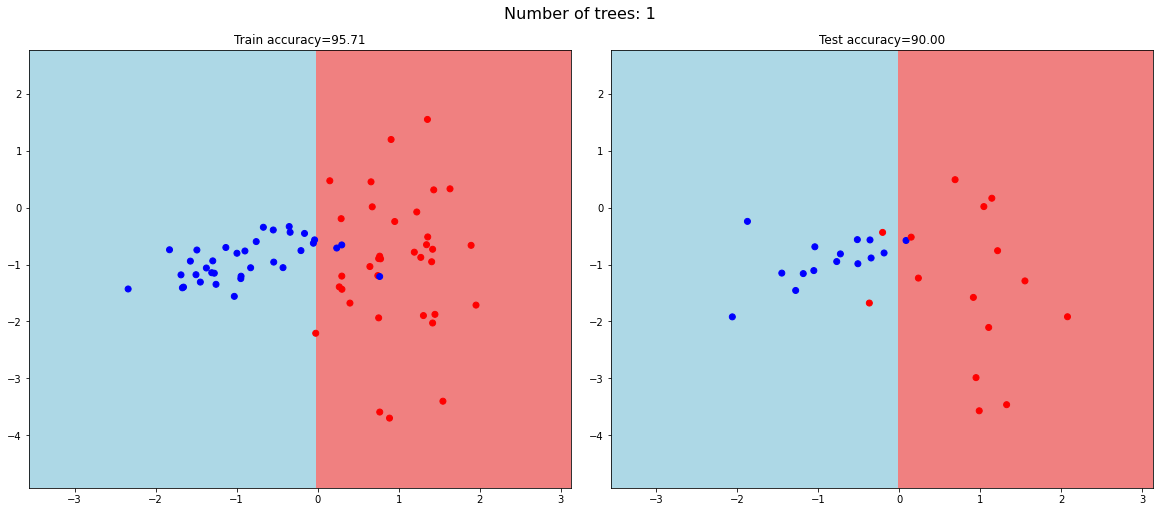

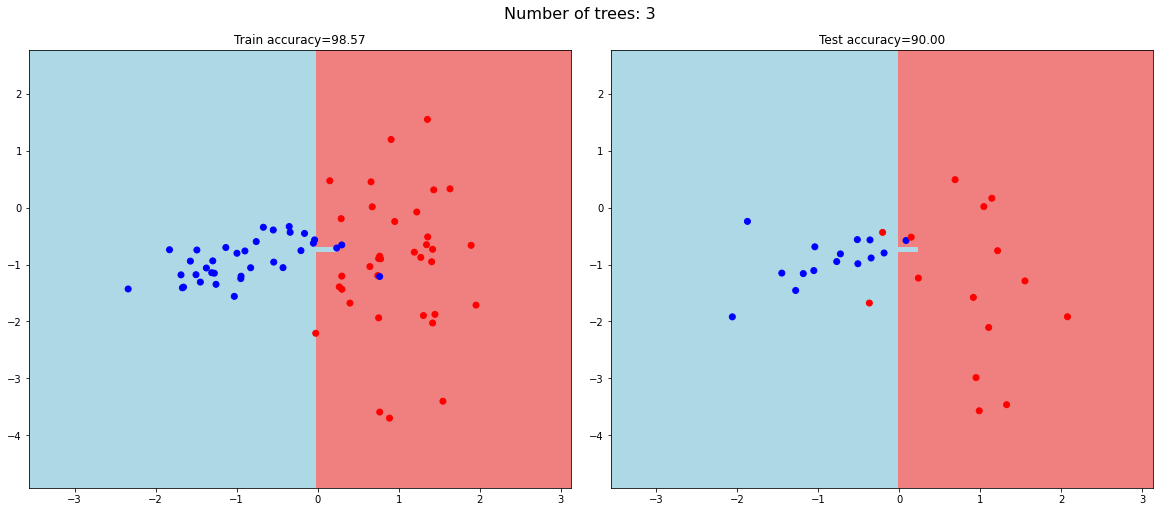

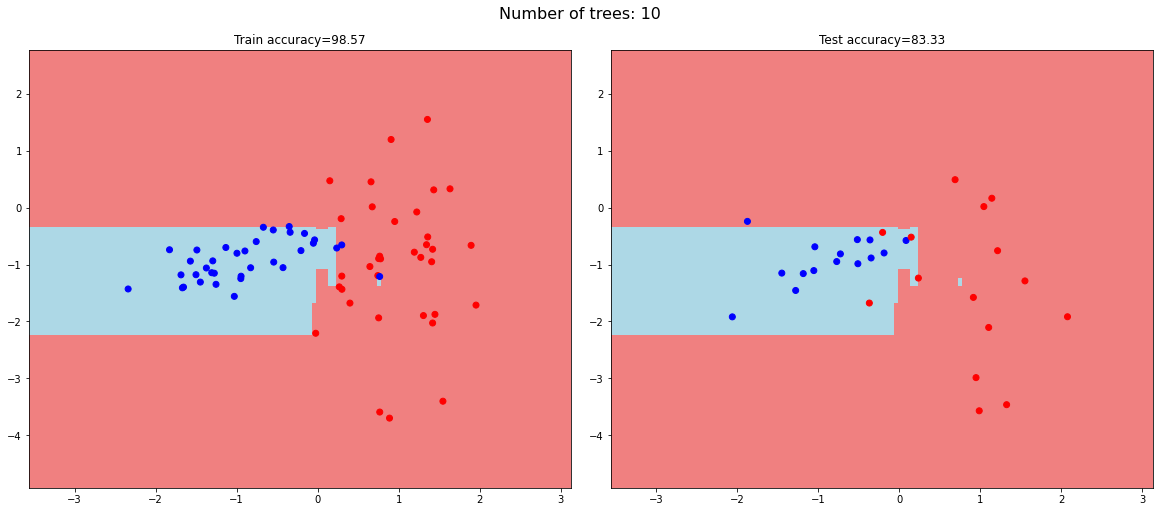

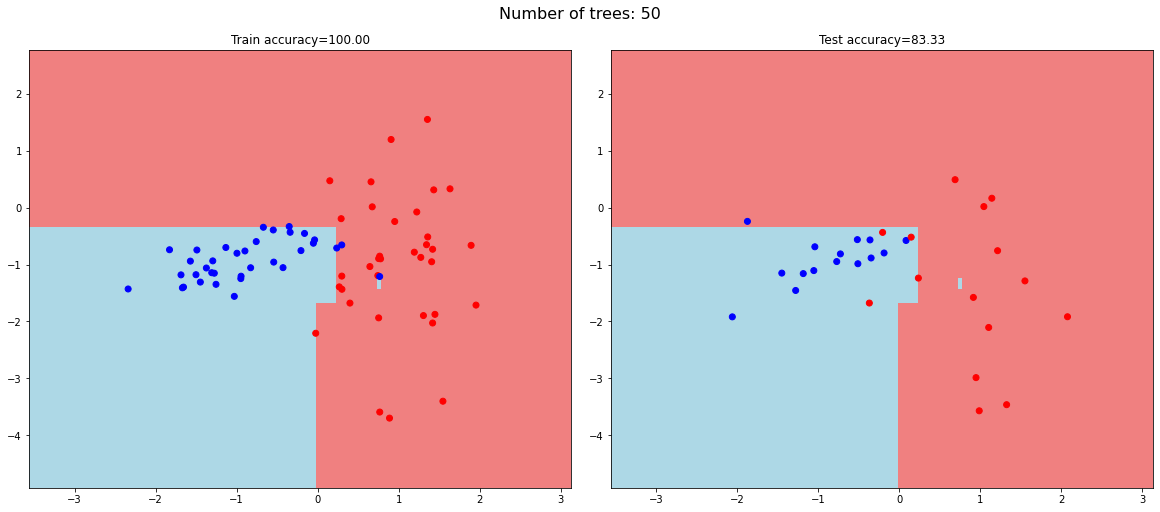

In [12]:
[visualize(train_data, test_data, result) for result in train_results]

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Выполнил несколько итераций, результаты кардинально разные.

В 1-м случае:
По цифрам видно, что лучше всего случайный лес обучился с 10-ю деревьями. При 50-и модель переобучилась и на тестовой выборке точность никак не изменилась. 

Разница сложностей гиперплоскостей очевидна между первыми двумя вариантами. Модель захватила больше пространства, что положительно повлияло на точность. При увеличении до 10 и до 50 деревьев гиперплоскость становится сложнее, с еле замеными мелкими деталями.

Во 2-м случае:
По цифрам модель лучше обучается на тренировочной выборке, но на тестовой точность не меняется. Аналогично с гиперплоскостями. Они становятся сложнее, но, в результате, для тестовых данных охват не меняется.

В 3-м случае:
Увеличение количества деревьев только уменьшало точность на тестовой выборке, т.е. модель переобучалась.

### 3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [13]:
from itertools import combinations
import random

# Генерация выборки с Out of Bag данными
def get_oob(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap_data = []
    oob_data = []
    
    for i in range(N):
        # 2/3 выборки - boostrap, 1/3 - out of bag
        bootstrap_indices = np.array(random.choice(list(combinations(range(n_samples), int(n_samples*2/3)))))
        oob_indecies = np.array([x for x in range(N) if x not in bootstrap_indices])
        
        b_data = data[bootstrap_indices]
        b_labels = labels[bootstrap_indices]
        bootstrap_data.append((b_data, b_labels))
        
        o_data = data[oob_indecies]
        o_labels = labels[oob_indecies]
        oob_data.append((o_data, o_labels))
        
    return bootstrap_data, oob_data

# Тест
get_oob(np.array(["d1", "d2", "d3"]), np.array(["1", "2", "3"]), 3)

([(array(['d1', 'd3'], dtype='<U2'), array(['1', '3'], dtype='<U1')),
  (array(['d2', 'd3'], dtype='<U2'), array(['2', '3'], dtype='<U1')),
  (array(['d2', 'd3'], dtype='<U2'), array(['2', '3'], dtype='<U1'))],
 [(array(['d2'], dtype='<U2'), array(['2'], dtype='<U1')),
  (array(['d1'], dtype='<U2'), array(['1'], dtype='<U1')),
  (array(['d1'], dtype='<U2'), array(['1'], dtype='<U1'))])

In [14]:
# Формирование случайного леса с учетом OOB
def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap, oob = get_oob(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, oob

# Предсказание голосованием деревьев для OOB
def tree_vote_oob(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions


def pipeline_oob(n_trees):
    forest, oob = random_forest_oob(train_data, train_labels, n_trees)
    train_answers = tree_vote_oob(forest, oob)
    test_answers = tree_vote_oob(forest, oob)
    _accuracy = accuracy(train_answers, test_answers, n_trees)
    return TrainResult(n_trees, forest, train_answers, test_answers, _accuracy)

# Вопрос: голосование по OOB. Где именно?

In [15]:
# pipeline_oob(1)

# crash

Не разобрался как заставить голосовать по OOB данным соответствующие деревья, которые не обучались на этих данных.